In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# **Veri Keşfi**

In [16]:
df = pd.read_csv("/content/drive/MyDrive/Colab çalışma/Neıman/müşteri/Year 2009-2010.csv", encoding='latin1')

In [17]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Invoice      525461 non-null  object 
 1   StockCode    525461 non-null  object 
 2   Description  522533 non-null  object 
 3   Quantity     525461 non-null  int64  
 4   InvoiceDate  525461 non-null  object 
 5   Price        525461 non-null  float64
 6   Customer ID  417534 non-null  float64
 7   Country      525461 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 32.1+ MB
None


In [18]:
# İlk birkaç satırı görelim
print(df.head())

  Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

      InvoiceDate  Price  Customer ID         Country  
0  12/1/2009 7:45   6.95      13085.0  United Kingdom  
1  12/1/2009 7:45   6.75      13085.0  United Kingdom  
2  12/1/2009 7:45   6.75      13085.0  United Kingdom  
3  12/1/2009 7:45   2.10      13085.0  United Kingdom  
4  12/1/2009 7:45   1.25      13085.0  United Kingdom  


In [19]:
# Veri setinde eksik değerlerin olup olmadığını kontrol edelim
print(df.isnull().sum())

Invoice             0
StockCode           0
Description      2928
Quantity            0
InvoiceDate         0
Price               0
Customer ID    107927
Country             0
dtype: int64


In [20]:
# Temel istatistikler
print(df.describe())

            Quantity          Price    Customer ID
count  525461.000000  525461.000000  417534.000000
mean       10.337667       4.688834   15360.645478
std       107.424110     146.126914    1680.811316
min     -9600.000000  -53594.360000   12346.000000
25%         1.000000       1.250000   13983.000000
50%         3.000000       2.100000   15311.000000
75%        10.000000       4.210000   16799.000000
max     19152.000000   25111.090000   18287.000000


# **Veri Önişleme**

In [21]:
# 'Customer ID' sütununda eksik değerleri doldurma veya kaldırma
df['Customer ID'] = df['Customer ID'].fillna(0)  # Veya df.dropna(subset=['Customer ID'], inplace=True)

# 'Description' sütununda eksik değerleri doldurma
df['Description'] = df['Description'].fillna('Unknown')

In [22]:
# Negatif veya sıfır değerlerdeki anormal miktarları kaldırma
df = df[df['Quantity'] > 0]
df = df[df['Price'] > 0]

# Tekrarlanan satırları kaldırma
df.drop_duplicates(inplace=True)

# InvoiceDate sütununu datetime tipine çevirme
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Veriyi yeniden kontrol etme
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 504731 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      504731 non-null  object        
 1   StockCode    504731 non-null  object        
 2   Description  504731 non-null  object        
 3   Quantity     504731 non-null  int64         
 4   InvoiceDate  504731 non-null  datetime64[ns]
 5   Price        504731 non-null  float64       
 6   Customer ID  504731 non-null  float64       
 7   Country      504731 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 34.7+ MB
None


In [23]:
print(df.isnull().sum())

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
dtype: int64


##  **Müşteri Segmentasyonu**

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


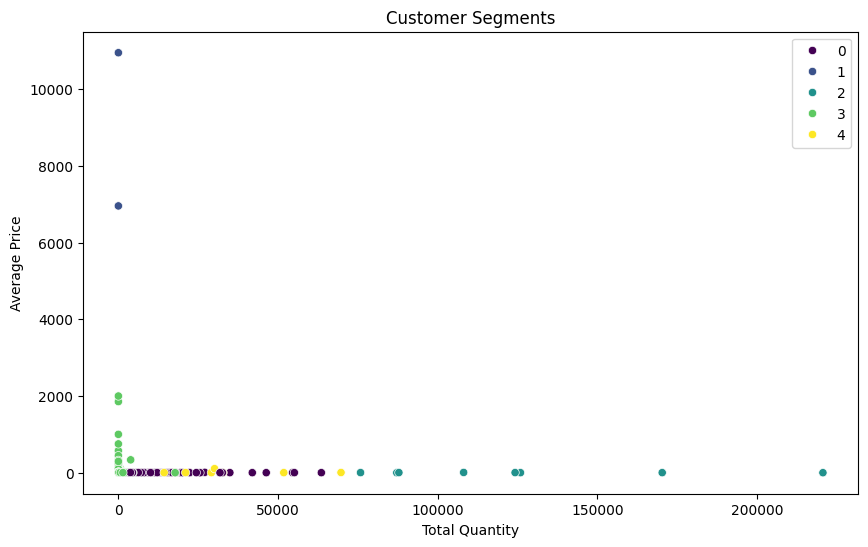

          Customer ID     Invoice       Quantity        Price
Segment                                                      
0        15275.556452   20.302419    6637.237903     3.192292
1        14339.000000    1.500000       1.500000  8955.835000
2        15050.500000   47.625000  124989.250000     2.852670
3        15354.599258    3.141409     643.343634     5.854177
4        15485.111111  120.777778   30144.555556    14.663408


In [25]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# 'Customer ID' 0 olan satırları filtreleme
df_customers = df[df['Customer ID'] != 0]

# Müşteri bazında özet veriyi hesaplama
customer_data = df_customers.groupby('Customer ID').agg({
    'Invoice': 'nunique',
    'Quantity': 'sum',
    'Price': 'mean'
}).reset_index()

# Özellikleri standardize etme
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_data[['Invoice', 'Quantity', 'Price']])

# K-Means modeli
kmeans = KMeans(n_clusters=5, random_state=42)
customer_data['Segment'] = kmeans.fit_predict(scaled_features)

# Segmentlerin görselleştirilmesi
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Quantity', y='Price', hue='Segment', data=customer_data, palette='viridis')
plt.title('Customer Segments')
plt.xlabel('Total Quantity')
plt.ylabel('Average Price')
plt.legend()
plt.show()

# Her segmentin özellikleri
print(customer_data.groupby('Segment').mean())

# **Satış Tahmini**

Mean Squared Error: 48572379272.95834


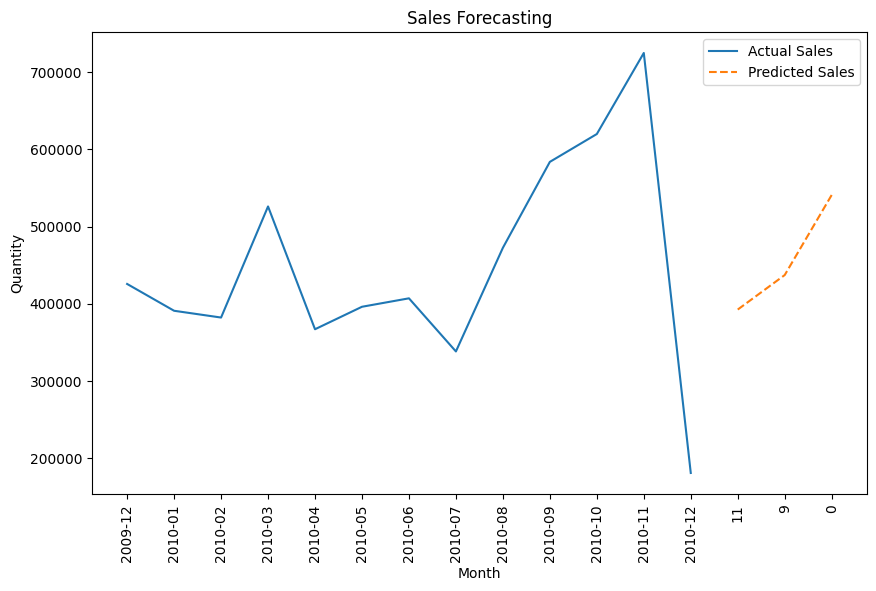

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Veriyi aylık bazda özetleme
df['Month'] = df['InvoiceDate'].dt.to_period('M')
monthly_sales = df.groupby('Month').agg({
    'Quantity': 'sum',
    'Price': 'mean'
}).reset_index()

# Özellikleri ve hedef değişkeni belirleme
X = monthly_sales[['Price']]
y = monthly_sales['Quantity']

# Veriyi eğitim ve test setlerine ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest modeli
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Modelin performansını değerlendirme
y_pred = model.predict(X_test)
print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred)}")

# Sonuçların görselleştirilmesi
plt.figure(figsize=(10, 6))
plt.plot(monthly_sales['Month'].astype(str), monthly_sales['Quantity'], label='Actual Sales')
plt.plot(X_test.index.astype(str), y_pred, label='Predicted Sales', linestyle='--')
plt.xticks(rotation=90)
plt.title('Sales Forecasting')
plt.xlabel('Month')
plt.ylabel('Quantity')
plt.legend()
plt.show()